## Detecting Twitter Bots

### Libraries

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

In [98]:
file= 'BotsData.csv'
TrainingData = pd.read_csv(file)
bot = TrainingData[TrainingData.bot==1]
nonbot = TrainingData[TrainingData.bot==0]

### Data Preprocessing

In [85]:
bot['friendsfollowersRatio'] = bot.friends_count/bot.followers_count
bot[bot.friendsfollowersRatio<1].shape

nonbot['friendsfollowersRatio'] = nonbot.friends_count/nonbot.followers_count
nonbot[nonbot.friendsfollowersRatio<1].shape

(952, 21)

In [101]:
###PUBLIC LISTS MEMBER BOT VS NONBOT

(504, 21)


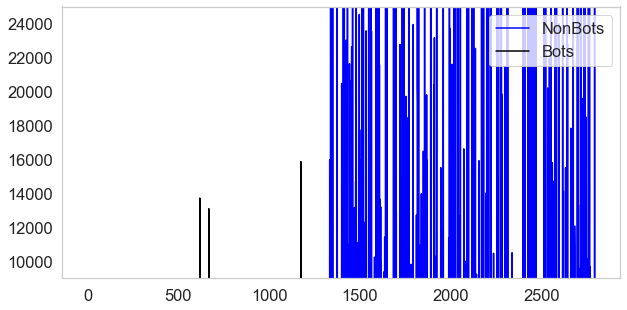

In [86]:
plt.figure(figsize=(10,5))
plt.plot(nonbot.listed_count, color='blue', label='NonBots')
plt.plot(bot.listed_count, color='black', label='Bots')
plt.legend(loc='upper right')
plt.ylim(9000,25000)
print(bot[(bot.listed_count<5)].shape)

In [87]:
botslistedcountdf = bot[bot.listed_count<16000]
nonbotslistedcountdf = nonbot[nonbot.listed_count<16000]

botsverifieddf = botslistedcountdf[botslistedcountdf.verified==False]
botsscreennamehasbotdf = botsverifieddf[(botsverifieddf.screen_name.str.contains("bot", case=False)==True)].shape

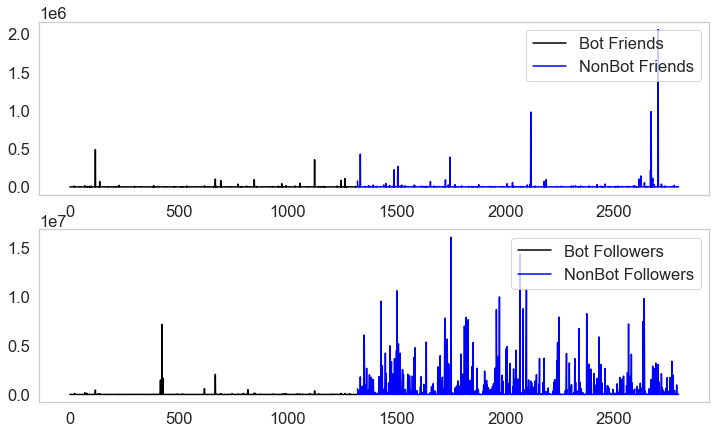

In [88]:
plt.figure(figsize=(12,7))

plt.subplot(2,1,1)
plt.plot(botslistedcountdf.friends_count, color='black', label='Bot Friends')
plt.plot(nonbotslistedcountdf.friends_count, color='blue', label='NonBot Friends')
plt.legend(loc='upper right')

plt.subplot(2,1,2)
plt.plot(botslistedcountdf.followers_count, color='black', label='Bot Followers')
plt.plot(nonbotslistedcountdf.followers_count, color='blue', label='NonBot Followers')
plt.legend(loc='upper right')

#### Bot detection metric (Account Activity)

In [89]:
condition = (bot.screen_name.str.contains("bot", case=False)==True)|(bot.description.str.contains("bot", case=False)==True)|(bot.location.isnull())|(bot.verified==False)

bot['screennamebinary'] = (bot.screen_name.str.contains("bot", case=False)==True)
bot['locationbinary'] = (bot.location.isnull())
bot['verifiedbinary'] = (bot.verified==False)
bot.shape

(1321, 24)

In [90]:
condition = (nonbot.screen_name.str.contains("bot", case=False)==False)| (nonbot.description.str.contains("bot", case=False)==False) |(nonbot.location.isnull()==False)|(nonbot.verified==True)

nonbot['screennamebinary'] = (nonbot.screen_name.str.contains("bot", case=False)==False)
nonbot['locationbinary'] = (nonbot.location.isnull()==False)
nonbot['verifiedbinary'] = (nonbot.verified==True)

nonbot.shape

(1476, 24)

In [91]:
df = pd.concat([bot, nonbot])
df.shape

(2797, 24)

In [92]:
file= open('BotsData.csv', mode='r', encoding='utf-8', errors='ignore')

TrainingData = pd.read_csv(file)

StopWords = r'bot|b0t|cannabis|tweet me|mishear|follow me|updates every|gorilla|yes_ofc|forget' \
                    r'expos|kill|bbb|truthe|fake|anony|free|virus|funky|RNA|kuck|jargon' \
                    r'nerd|swag|jack|bang|bonsai|chick|prison|paper|pokem|freak|ffd|dunia|clone|genie|bbb' \
                    r'ffd|onlyman|emoji|joke|troll|droop|free|every|wow|cheese|yeah|bio|magic|wizard|face'

###STOP WORDS TAKEN FROM https://github.com/martha92/MeTooAnalysis/blob/e2dd051866a79ccb065507d304dfd98168e6b0c2/bot_human/bot_human_custom.py
            
TrainingData['screennamebinary'] = TrainingData.screen_name.str.contains(StopWords, case=False, na=False)
TrainingData['namebinary'] = TrainingData.name.str.contains(StopWords, case=False, na=False)
TrainingData['descriptionbinary'] = TrainingData.description.str.contains(StopWords, case=False, na=False)
TrainingData['statusbinary'] = TrainingData.status.str.contains(StopWords, case=False, na=False)

In [95]:
TrainingData['listedcountbinary'] = (TrainingData.listed_count>20000)==False
feature = ['screennamebinary', 'namebinary', 'descriptionbinary', 'statusbinary', 'verified', 'followers_count', 'friends_count', 'statuses_count', 'listedcountbinary', 'bot']

#### Decision Tree Classifier

In [96]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.model_selection import train_test_split

X = TrainingData[feature].iloc[:,:-1]
y = TrainingData[feature].iloc[:,-1]

dt = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=50, min_samples_split=10)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)

dt = dt.fit(X_train, y_train)
y_pred_train = dt.predict(X_train)
y_pred_test = dt.predict(X_test)


print("Trainig Accuracy: %.5f" %accuracy_score(y_train, y_pred_train))
print("Test Accuracy: %.5f" %accuracy_score(y_test, y_pred_test))


Trainig Accuracy: 0.88412
Test Accuracy: 0.87429
